In [1]:
import torch 
import albumentations as alb
import pandas as pd
import numpy as np
import os, os.path
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from torch.profiler import profile, record_function, ProfilerActivity, schedule
from torchmetrics import Accuracy
import gc
from sklearn.metrics import classification_report, confusion_matrix

c:\Users\Zakaria\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Preprocessing data

# We need to calculate the mean and std of pixel values for out image set in order to use it for normalization
# Load dataset without normaliztion
dataset= datasets.ImageFolder( # datasets.ImageFolder loads images following folder structure
    root= "dataset",
    transform= transforms.Compose([
        transforms.Grayscale(num_output_channels=1), # Ensure images are grayscale
        transforms.Resize((255,255)),
        transforms.ToTensor() # Convert to Tensors
    ])
)

dataloader= DataLoader(dataset, batch_size=32, shuffle= False)




In [9]:
basic_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def get_metrics(root, transform):
    # Compute mean and std
    dataset = datasets.ImageFolder(root, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    mean= 0
    std= 0
    n_batches= 0
    for images, _ in loader:
        batch_size= images.size(0)
        images= images.view(batch_size, images.size(1), -1) # Flatten height and width so every batch is made out of images of size (batch_size, 1 (channel), height*width)
        mean+= images.mean(2).sum(0) # Calculte the mean over the dimention of pixels, then sums over the batch size dimention to get a sum of all means
        std+= images.std(2).sum(0) # Same thing with std
        n_batches+= batch_size

    mean /= n_batches
    std /= n_batches

    print(f"mean: {mean}, std: {std}")
    return (mean, std)


train_mean, train_std= get_metrics("dataset/train", basic_transform)
# Train transformer
train_transform= transforms.Compose([
    transforms.Resize((224,224)), # Resize
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(7), # Data augmentations
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=214,pad_if_needed= True),
    #transforms.RandomPerspective(distortion_scale=0.1),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust brightness, contrast, and saturation
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean= train_mean, std=train_std)
])


# Val transformer
val_test_transform= transforms.Compose([
    transforms.Resize((224,224)), # Resize
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean= train_mean, std=train_std)
])


# Transform datasets
train_dataset= datasets.ImageFolder(root= "dataset/train", transform=train_transform)
val_dataset= datasets.ImageFolder(root="dataset/val", transform= val_test_transform)
test_dataset= datasets.ImageFolder(root="dataset/test", transform= val_test_transform)

# Load data
batch_size= 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory= True)



val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory= True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory= True)

mean: tensor([0.4823]), std: tensor([0.2216])


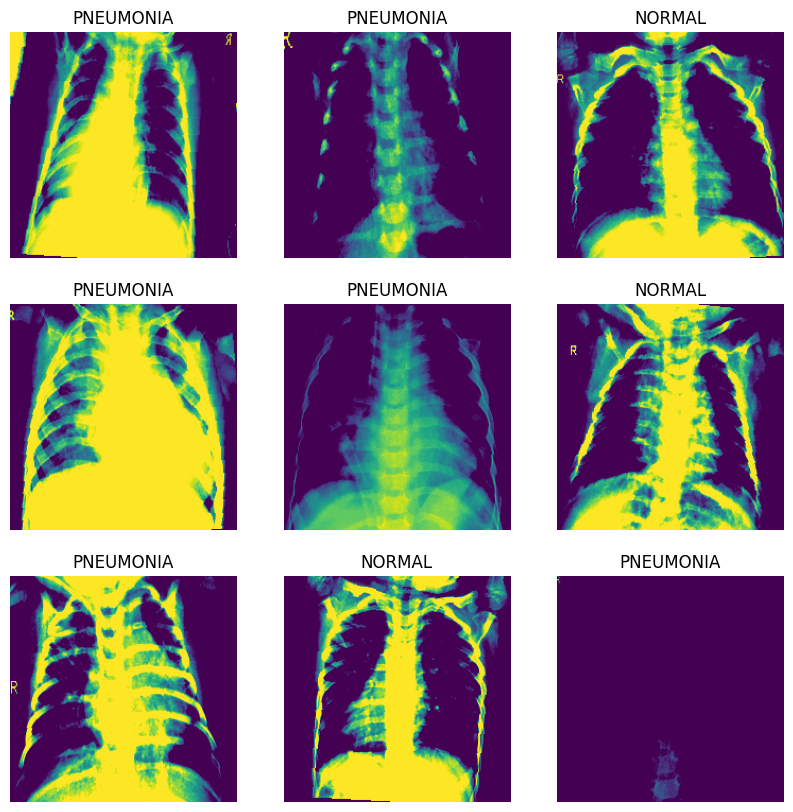

In [10]:
# Function to display images
def show_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):  # Show up to 9 images
        plt.subplot(3, 3, i + 1)
        img = images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C) for visualization
        img = torch.clamp(img, 0, 1)  # Clamp values to [0, 1] for display
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

# Get a batch of images
images, labels = next(iter(train_loader))

# Show images
class_names = train_dataset.classes  # Get class names from the dataset
show_images(images, labels, class_names)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()

        # Convolutional blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 1)
        #self.fc3 = nn.Linear(64, 1)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.pool(self.conv1(x))  # 1 → 32
        x = self.pool(self.conv2(x))   # 32 → 64
        x = self.pool(self.conv3(x))   # 64 → 128

        x = self.gap(x) 
        x = x.view(x.size(0), -1)  # Flatten: (B, 256*7*7)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [12]:
# Select GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model
model = PneumoniaCNN().to(device)

# Print model architecture
print(model)

PneumoniaCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
)


In [13]:
# Hyperparameters
num_epochs= 20
learning_rate= 0.0001

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)


In [14]:
# Training loop

# Initialize accuracy metrics
train_accuracy = Accuracy(task="binary").to(device)  # Make sure to specifiy binary classification and not multiclass
val_accuracy = Accuracy(task="binary").to(device)
best_val_accuracy = 0.0  # Track the best validation accuracy

for epoch in range(num_epochs):
    model.train() # set to train mode
    train_loss = 0.0 # Keep track of epoch loss

    for inputs, labels in train_loader:
        # Move to GPU
        inputs, labels = inputs.to(device), labels.to(device).float()

        # Forward pass
        outputs= model(inputs)
        loss= criterion(outputs.squeeze(), labels) # Squeeze the outputs to make sure the size matches with the labels. Both should be [batch_size]

        # Zero gradients
        optimizer.zero_grad()

        # Backpropagation
        loss.backward()
        
        # Take a step
        optimizer.step()
        

        # Updte running loss
        train_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float().squeeze()  # For binary classification
        train_accuracy.update(predicted, labels)

    # Calculate training loss nd accurace
    train_acc= train_accuracy.compute()
    train_loss /= len(train_loader)
    
    # Validation
    model.eval() # set to eval mode
    val_loss= 0.0

    with torch.no_grad(): # Stop keeping track of gradients
        for inputs, labels in val_loader:
            inputs, labels= inputs.to(device), labels.to(device).float()

            # Forward pass
            outputs= model(inputs)
            loss= criterion(outputs.squeeze(), labels.float())

            # Update val loss and accuracy
            val_loss += loss.item()
            predicted= (outputs > 0.5).float().squeeze()
            val_accuracy.update(predicted, labels)

    # Caluclate val loss and accuracy
    val_acc= val_accuracy.compute()
    val_loss /= len(val_loader)
    scheduler.step(val_loss)


    # Print results
    print(f"Epoch: [{epoch+1}/{num_epochs}],"
          f"Train accuracy: {train_acc:.4f}, train loss: {train_loss:.4f},"
          f"Validation accuracy: {val_acc:.4f}, validation loss: {val_loss:.4f}")
    
    # Save the best model based on validation accuracy
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved best model!")
    
    # Reset metrics for the next epoch
    train_accuracy.reset()
    val_accuracy.reset()

# Release memory
del inputs, labels, outputs, loss # Delete variables
gc.collect()
torch.cuda.empty_cache() 
model = model.to('cpu') # Move model to cpu for garbage collection
del model
gc.collect()
torch.cuda.empty_cache()

Epoch: [1/20],Train accuracy: 0.7843, train loss: 0.4497,Validation accuracy: 0.7660, validation loss: 0.5404
Saved best model!
Epoch: [2/20],Train accuracy: 0.8497, train loss: 0.3380,Validation accuracy: 0.7452, validation loss: 0.6078
Epoch: [3/20],Train accuracy: 0.8652, train loss: 0.3031,Validation accuracy: 0.6923, validation loss: 0.7576
Epoch: [4/20],Train accuracy: 0.8886, train loss: 0.2722,Validation accuracy: 0.7404, validation loss: 0.6370
Epoch: [5/20],Train accuracy: 0.9043, train loss: 0.2412,Validation accuracy: 0.7740, validation loss: 0.6099
Saved best model!
Epoch: [6/20],Train accuracy: 0.9078, train loss: 0.2295,Validation accuracy: 0.7917, validation loss: 0.5324
Saved best model!
Epoch: [7/20],Train accuracy: 0.9022, train loss: 0.2364,Validation accuracy: 0.7372, validation loss: 0.6831
Epoch: [8/20],Train accuracy: 0.9103, train loss: 0.2177,Validation accuracy: 0.7388, validation loss: 0.7475
Epoch: [9/20],Train accuracy: 0.9120, train loss: 0.2160,Validatio

In [15]:
# Testing loop
# Load the best model
model = PneumoniaCNN()  # Replace with your actual model class
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)

# Initialize test accuracy metric
test_accuracy = Accuracy(task="binary").to(device)

# Set model to evaluation mode
model.eval()
test_loss = 0.0
all_predictions = []
all_labels = []

print("Starting model testing...")

with torch.no_grad():  # Disable gradient computation for testing
    for inputs, labels in test_loader:
        # Move to GPU
        inputs, labels = inputs.to(device), labels.to(device).float()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        
        # Update test loss
        test_loss += loss.item()
        
        # Get predictions
        predicted = (outputs > 0.5).float().squeeze()  # For binary classification
        
        # Update accuracy metric
        test_accuracy.update(predicted, labels)
        
        # Store predictions and labels for additional analysis if needed
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate final test metrics
test_acc = test_accuracy.compute()
test_loss /= len(test_loader)

# Print test results
print(f"Test Results:")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")



# Convert to numpy arrays for sklearn
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Print detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=['Class 0', 'Class 1']))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_predictions))

# Reset metrics
test_accuracy.reset()

# Release memory
del inputs, labels, outputs, loss, predicted, all_predictions, all_labels
gc.collect()
torch.cuda.empty_cache()
model = model.to('cpu')  # Move model to cpu for garbage collection
del model
gc.collect()
torch.cuda.empty_cache()

print("Testing completed and memory released.")

C:\Users\Zakaria\AppData\Local\Temp\ipykernel_5704\2101987274.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Starting model testing...
Test Results:
Test accuracy: 0.6875
Test loss: 0.9947

Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.38      0.55         8
     Class 1       0.62      1.00      0.76         8

    accuracy                           0.69        16
   macro avg       0.81      0.69      0.65        16
weighted avg       0.81      0.69      0.65        16


Confusion Matrix:
[[3 5]
 [0 8]]
Testing completed and memory released.
